In [1]:
import sys
import matplotlib.pyplot as plt
from contextualbandits import online as cb
from copy import deepcopy as clone
import numpy as np
import pandas as pd
# The only classifiers that have partial_fit
# See: https://scikit-learn.org/0.15/modules/scaling_strategies.html
from sklearn.linear_model import SGDClassifier, PassiveAggressiveClassifier, Perceptron
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
sys.path.append("../src")

%matplotlib inline
from wrappers import *

In [2]:
desired_win_rate=0.33

df = pd.read_csv("../data/data.csv")
df = df[df['adNetworkId'].isin([172, 108, 497])]

df = df.query("placementType=='banner' and bidPrice<2 and bidPrice>0.1").sample(frac=0.02)

# Read data & preprocess

In [3]:
def keep_values_by_min_freq(df, col, freq=0.9,other="OTHER"):
    ds = df[col].value_counts(normalize=True).cumsum()
    mapped2other = []
    marked_as_other = False
    for val, prop in ds.iteritems():
        if marked_as_other:
            mapped2other.append(val)
        if prop>freq:
            marked_as_other=True
    df.loc[df[col].isin(mapped2other), col]=other
    df[col] = df[col].astype('category')
    
    return df

In [4]:
def preprocess(df):
    df = df.drop("sessionId", axis=1)
    df["eventTimestamp"] = pd.to_datetime(df["eventTimestamp"]*1_000_000)
#     df["day_of_week"]=df["eventTimestamp"].dt.weekday.astype("category")
#     df["time_of_day"]=df["eventTimestamp"].dt.hour.astype("category")
    df.sort_values(by='eventTimestamp', inplace=True)
    df = df.drop("eventTimestamp", axis=1)
    print(df.head())
    print(df.columns)
    for col, dtype in df.dtypes.iteritems():
        if str(dtype) == 'object':
            df = keep_values_by_min_freq(df, col)
    
#     df = keep_values_by_min_freq(df, 'adNetworkId')
#     df = keep_values_by_min_freq(df, 'userTrackingAuth')
    # a, r, X for models
    df["arms"] = df["bidPrice"].round(2)
    arms = sorted(list(df["arms"].unique()))
    # Add the logic of: "If $5 won, then $6 would have won as well" (also for loss)
    df["arms"] = df.apply(lambda row: [a for a in arms if a>=row["arms"]] if row["hasWon"] else
                          [a for a in arms if a<=row["arms"]],axis=1)
    df = df.explode("arms")
    arm_dict = {a:i for i, a in enumerate(arms)}
    a = df["arms"].map(arm_dict)
    r = df["hasWon"]
    b = df['bidPrice']
    df = df.drop(["bidPrice", "hasWon", "arms"] ,axis=1)
    df["dnt"] = df["dnt"].astype(object)
    df["userTrackingAuth"] = df["userTrackingAuth"].astype(object)
    df["adNetworkId"] = df['adNetworkId'].astype(object)
    X = pd.get_dummies(df)
    return arm_dict, X, a, r, b

# def preprocess_only_one_feature(df, feature='deviceOs'):
#     # preprocess
#     df = df[['bidPrice', 'hasWon', feature]]
#     df["arms"] = df["bidPrice"].round(1)
#     arms = sorted(list(df["arms"].unique()))
#     # Add the logic of: "If $5 won, then $6 would have won as well" (also for loss)
#     df["arms"] = df.apply(lambda row: [a for a in arms if a>=row["arms"]] if row["hasWon"] else
#                           [a for a in arms if a<=row["arms"]],axis=1)
#     df = df.explode("arms")
    
#     arm_dict = {a:i for i, a in enumerate(arms)}
#     a = df["arms"].map(arm_dict)
#     r = df["hasWon"]
#     df = df.drop(["bidPrice", "hasWon", "arms"] ,axis=1)
#     X = pd.get_dummies(df)
    
#     return arm_dict, X, a, r


# sample
### Note for arms - we should know in advance, per each context, what is the maximum bid
# e.g. for iOS, size=320x50, plc=Banner, we should know that 10 is the maximum and not create an arm for X>10...
# Maybe - it should be calculated every X days (1 day...)

# df = df.query("placementType=='banner' and bidPrice<1.01").drop("placementType",axis=1)
relevant_drop_cols = ['placementType', 'bundleId', 'advertisedBundle']
df.drop(relevant_drop_cols, axis=1, inplace=True)

arm_dict, X, a, r, bidprices = preprocess(df)
# df["deviceOs_size"] = df["deviceOs"] + '_' + df["size"]
# arm_dict, X, a, r = preprocess_only_one_feature(df, 'deviceOs_size')

         adNetworkId  bidPrice  hasWon     size    dnt deviceOs  \
1096431          172  0.194601       1   320x50  False  Android   
112995           172  0.224260       0  300x250   True      iOS   
113063           172  0.536363       0   320x50  False      iOS   
1096477          497  0.494000       1   320x50  False      iOS   
141149           108  0.227000       0   320x50   True      iOS   

         userTrackingAuth  
1096431                 1  
112995                  5  
113063                  7  
1096477                 7  
141149                  6  
Index(['adNetworkId', 'bidPrice', 'hasWon', 'size', 'dnt', 'deviceOs',
       'userTrackingAuth'],
      dtype='object')


In [5]:
X.shape

(589887, 18)

# Contextual bandits

In [6]:
class ModelWithDesiredWinRate(BernoulliNB):
    def predict_proba(self, X):
        probs = super().predict_proba(X)[:, 1] # predict proba as of any predict_proba model classifier
        y = 1 / np.abs(probs - desired_win_rate + 0.0001) # Numerical stability
        c = 1e-3
        y = 1 - np.exp(-y*c) # Normalize
        ret = np.vstack((1-y, y)).T

        return ret

In [7]:
class SGDClassifierWithNormalization(SGDClassifier):
    def predict_proba(self, X):
        probs = super().predict_proba(X)[:, 1] # predict proba as of any predict_proba model classifier
        y = 1 / np.abs(probs - desired_win_rate + 0.0001) # Numerical stability
        c = 1e-3
        y = 1 - np.exp(-y*c) # Normalize
        ret = np.vstack((1-y, y)).T

        return ret

In [8]:
n_arms = len(arm_dict)
bids = {v:k for k,v in arm_dict.items()}
base_model = SGDClassifierWithNormalization(loss='log')
# base_model = ModelWithDesiredWinRate()
# base_model = BernoulliNB()
logreg_sg = cb.SeparateClassifiers(clone(base_model), n_arms, batch_train=True)

In [9]:
logreg_sg.partial_fit(X,a,r)
print(type(logreg_sg._oracles.algos[0]))
assert type(base_model) == type(logreg_sg._oracles.algos[0])

# model.partial_fit(XX, aa, rr)
# [m.coef_ for m in model._oracles.algos]

<class '__main__.SGDClassifierWithNormalization'>


In [10]:
# logreg_sg.fit(X,a,r)
# [m.coef_ for m in logreg_sg._oracles.algos]

In [27]:
def simulate(model, X, a , r, b, chunk = 100, limit=500):
    X,a,r=map(clone,[X,a,r]) # copy the existing data so we won't change it
    
    ### TODO: Update reward with neighbor arms
    
    train_X, train_a, train_r, train_b = X.iloc[:chunk,:], a[:chunk], r[:chunk], b[:chunk]
    # split the data into train
    # Get chunk data points for first input
    X, a, r, b = X.iloc[chunk:,:], a[chunk:], r[chunk:], b[chunk:]
    test_X, test_a, test_r, test_b = X.iloc[:chunk,:], a[:chunk], r[:chunk], b[:chunk]
    n_iterations = 1
    regrets = []
    #TODO: Add initial train
    model.partial_fit(train_X,train_a,train_r)
    while len(X)>chunk:
        model.partial_fit(train_X,train_a,train_r)
        pred_bids = model.predict(test_X)
        ### TODO: regret should be: real bid - predicted bid if won; if lose: some factor of bad high stuff.
        regrets.append(np.sum([np.abs(bids[i]-y) for i,y in zip(pred_bids,test_b.values)])/chunk)
        train_X, train_a, train_r    = X.iloc[:chunk,:], a[:chunk], r[:chunk]
        X, a, r = X.iloc[chunk:,:], a[chunk:], r[chunk:]
        test_X, test_a, test_r = X.iloc[:chunk,:], a[:chunk], r[:chunk]
        n_iterations+=1
        if limit>0 and limit<n_iterations:
            break
            
    return regrets

# plot

Text(0.5, 0, 'iterations')

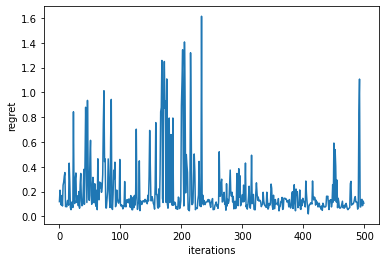

In [29]:
regret = simulate(logreg_sg, X, a, r, bidprices)
plt.plot(np.arange(len(regret)), regret)
plt.ylabel("regret")
plt.xlabel("iterations")

(0.0, 0.3)

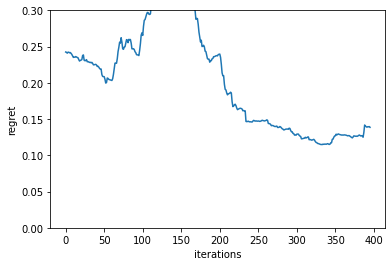

In [37]:
window_size=105
regret_smooth=np.convolve(regret,np.ones(window_size), 'valid')/window_size
plt.plot(np.arange(len(regret_smooth)), regret_smooth)
plt.ylabel("regret")
plt.xlabel("iterations")
plt.ylim((0,0.3))

In [ ]:
print (np.mean(regret), np.median(regret))
plt.hist(regret, bins=100)

In [ ]:
print(X.columns)
pred = logreg_sg.predict(np.eye(len(X.columns)), output_score=True)
pred["bid"] = [bids[y] for y in pred['choice']]
pred

In [ ]:
df.groupby("deviceOs").agg({"bidPrice": np.mean, "sessionId": 'count'})

In [ ]:
df.pivot_table(values="bidPrice", index="deviceOs", columns="hasWon", aggfunc='median')

In [ ]:
df.pivot_table(values="bidPrice", index="size", columns="hasWon", aggfunc='median')

In [ ]:
df.query('hasWon==1').pivot_table(values="bidPrice", index="deviceOs", columns="size", aggfunc='median')

In [20]:
### TODO: Explode solution is nice but we have a lot of memory issues with it. It's hacky
# 1. Instead: For loop inside simulate >>> partial fit "on the fly"
# 2. Add loops of features and maybe think on other datasets
# 3. Make some presentation for Gil with some math
# 4. Work on presentation